# The Heat Semigroup for image processing 

##### In this notebook, we show how the [heat semigroup](https://www.math.ucdavis.edu/~hunter/m218a_09/ch5) can be used for image corruption, restoration and compression. 

##### We demonstrate the process on three very different types of images: satellite; cartoon; architectural.  

##### The semigroup and diffusion notebooks are structured in the same manner. It may be interesting to compare the notebooks side by side.

We begin by importing an approximation for the [heat kernel on the square](https://en.wikipedia.org/wiki/Heat_kernel), which is given by one of the [Jacobi-Theta functions](https://en.wikipedia.org/wiki/Theta_function#A_solution_to_the_heat_equation). This will serve as our convolution kernel.

In [1]:
from heatdiff.heat_kernel_utils import jacobi_theta_2d

By the theory of parabolic equations - the heat equation is a parabolic equation - the time variable has the same scaling factor as the distance squared. Equivalently, the square root of time scales like the distance. As a result, we will choose the time variable to be the square root of the spatial variable for the convolution kernel.

In [2]:
jacobi_9 = jacobi_theta_2d(3,9) # we have chosen two integer values but this is not important 

### Satellite image

Let us import an image 

In [3]:
import cv2 as cv 
from heatdiff.plotting_utils import plot_input 
from heatdiff.image_preprocessing import normalize_image 

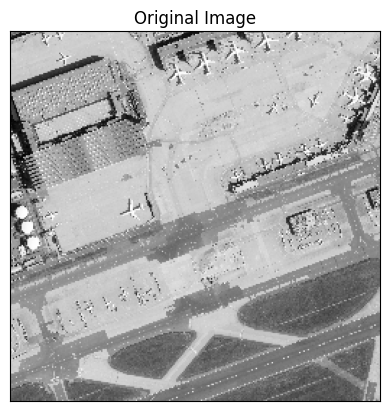

In [4]:
original_img = cv.imread('../images/dop20_32_468_5543_1_he.jpg', 0) 
original_img = cv.resize(original_img, (256,256)) 
normalised_img = normalize_image(original_img)
plot_input(original_img, 'Original Image')

Now, we apply the reverse heat semigroup for 10000 steps. Note that the larger the number of steps, the better the approximation to the reverse heat equation and hence a better performance.

We obtain the reverse heat equation via the [reverse Brownian motion](https://en.wikipedia.org/wiki/Wiener_process#Time_reversal). This is possible due to the [Feynman-Kac formula](https://www.stat.uchicago.edu/~lalley/Courses/391/Lecture12.pdf).

In [5]:
from heatdiff.heat_equations import reverse_heat_equation

In [6]:
stl_rev, stl_fwd = reverse_heat_equation(jacobi_9, original_img, 10000)

Let's take a look at how the image is corrupted and then reconstructed. We visualise the first few steps and the final step. Note that the larger the number of steps, the lower the mean squared error between the original image and its reconstruction. Note that for the reconstruction process, the 0th image is the final step.

In [7]:
from heatdiff.plotting_utils import plot_images

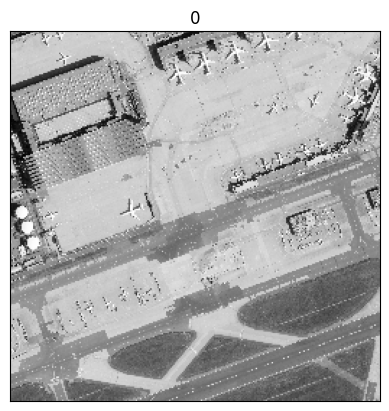

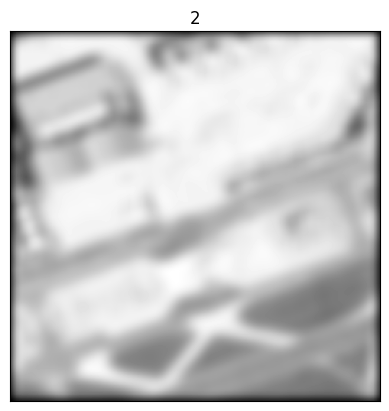

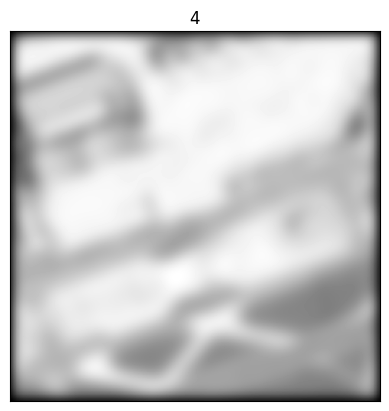

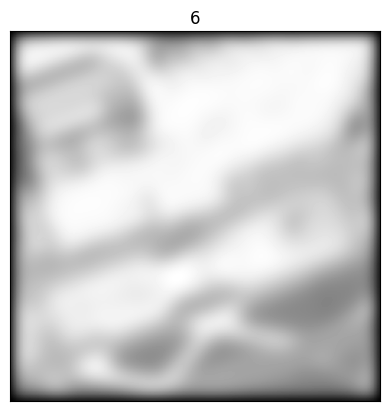

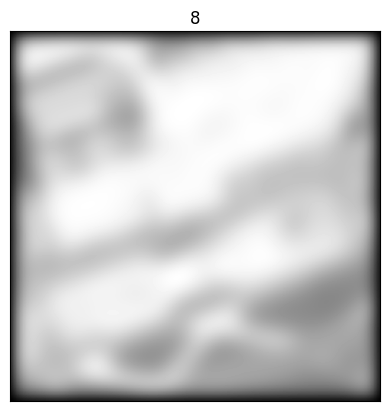

In [8]:
plot_images(stl_fwd[0:10],2)

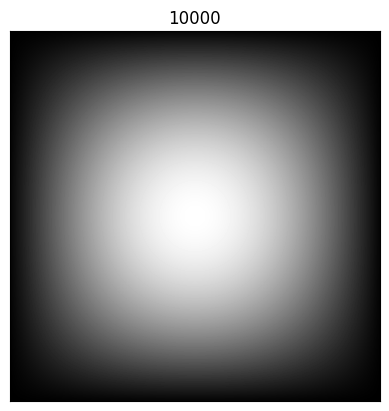

In [9]:
plot_input(stl_fwd[-1], '10000')

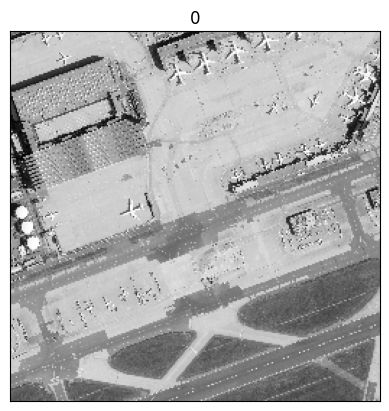

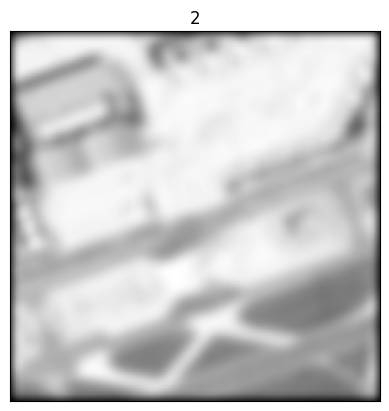

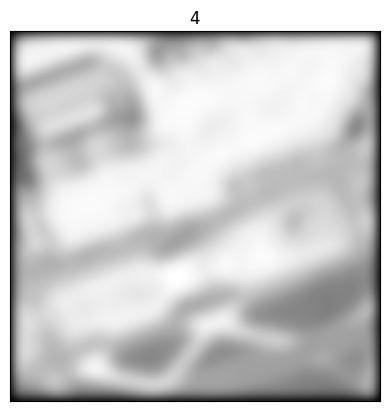

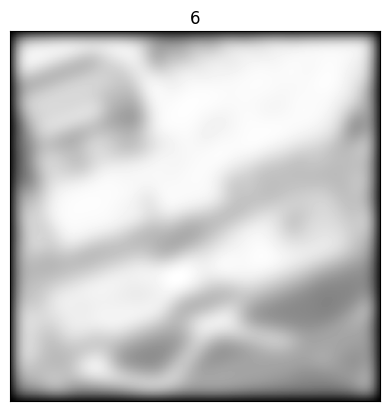

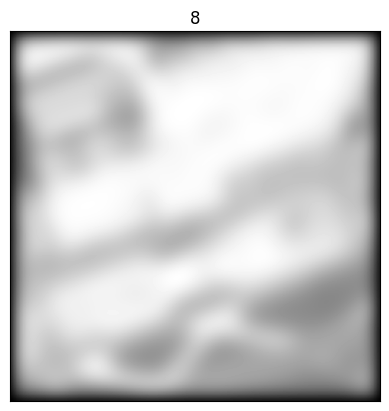

In [10]:
plot_images(stl_rev[0:10],2)

After putting the reconstructed image into the 0-255 pixel range, let us visually compare the two images and their distributions. 

In [11]:
from heatdiff.image_preprocessing import normal_range
from heatdiff.plotting_utils import subplot_2, compare_norm_histograms

In [12]:
reconstructed_stl = normal_range(stl_rev[0])

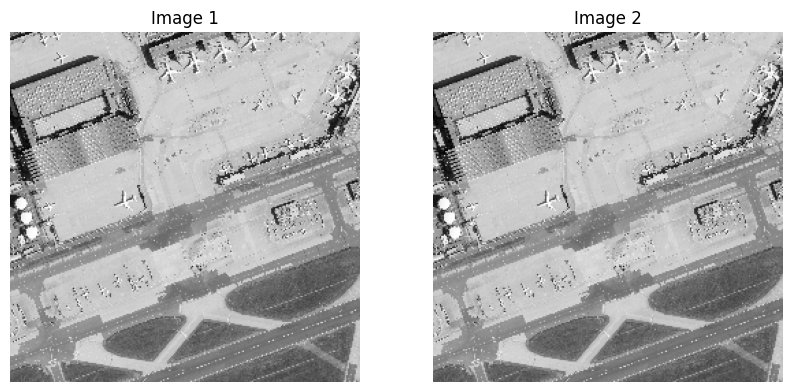

In [13]:
subplot_2(original_img, reconstructed_stl)

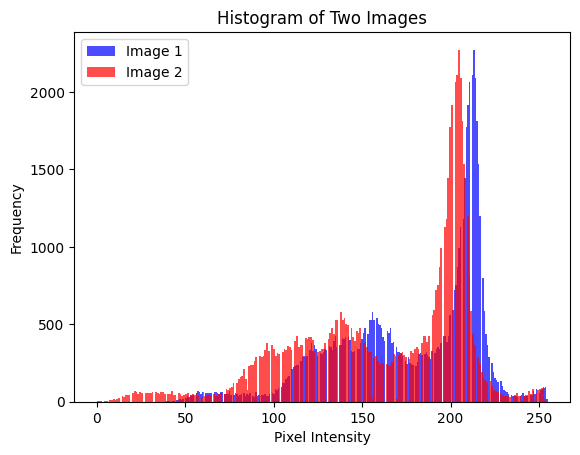

In [14]:
compare_norm_histograms(original_img, reconstructed_stl)

We note that the histograms are quite similar (compare this to the diffusion_demo notebook).

Now, let us compare the mean square error. We will normalise both images so that it makes for a much more interpretable comparison.

In [15]:
from heatdiff.image_accuracy import mse

In [16]:
mse(normalised_img, normalize_image(reconstructed_stl)) * 100 # To have it as a percentage 

0.0005262099124862229

As previously stated, increasing the number of steps greatly decreases the mean squared error as well as the visual loss. 

#### Compression 

We will use a weighted K-means to compress the image. We do this by reducing the range of pixel intensity from 256 to 8 (random choice.) The weight in the K-means algorithm is the jacobi theta function, which as we stated, is the approximation of the heat kernel on the square.

In [17]:
from heatdiff.compression import jacobi_compression

In [18]:
compressed_stl, centres = jacobi_compression(reconstructed_stl, 8)

In [19]:
compressed_stl = normal_range(compressed_stl)

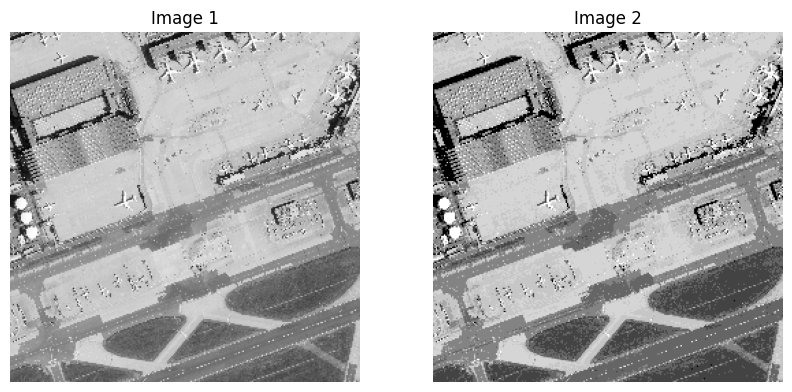

In [20]:
subplot_2(original_img, compressed_stl)

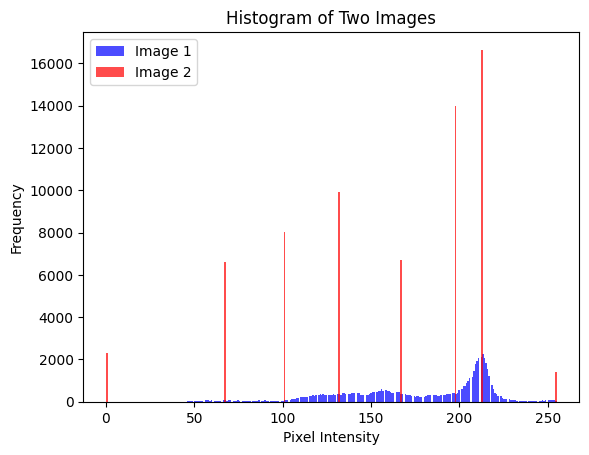

In [21]:
compare_norm_histograms(original_img, compressed_stl)

Lets check the mean squared error. 

In [22]:
mse(normalised_img, normalize_image(reconstructed_stl)) * 100, mse(normalised_img, normalize_image(compressed_stl)) * 100

(0.0005262099124862229, 0.33612494250256575)

Next, we can investigate the number of bits that we have saved per pixel. This is done via the Shannon Entropy 

In [23]:
import skimage.measure   

In [24]:
entropy_orig = skimage.measure.shannon_entropy(original_img) 
entropy_compressed_stl = skimage.measure.shannon_entropy(compressed_stl) 

entropy_orig, entropy_compressed_stl

(6.906971294514111, 2.7177543555710244)

### Cartoon image

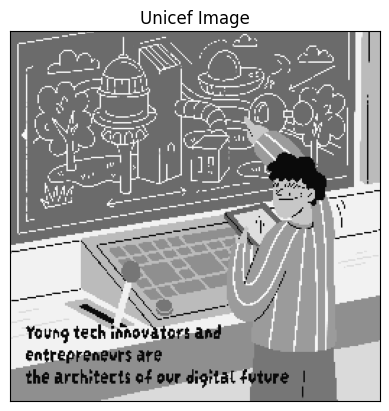

In [25]:
unicef_img = cv.imread('../images/unicef-qlf-pOEPZ40-unsplash.jpg', 0) 
unicef_img = cv.resize(unicef_img, (256,256)) 
unicef_normal = normalize_image(unicef_img)
plot_input(unicef_img, 'Unicef Image')

In [26]:
unicef_rev, unicef_fwd = reverse_heat_equation(jacobi_9, unicef_img,10000)

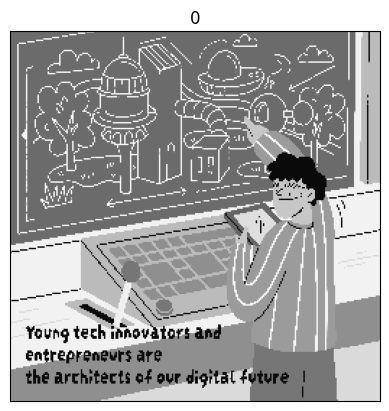

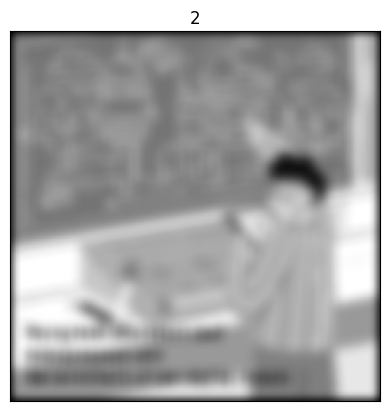

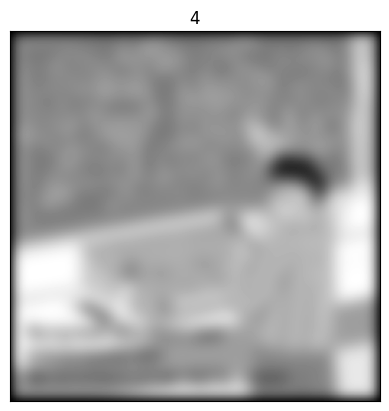

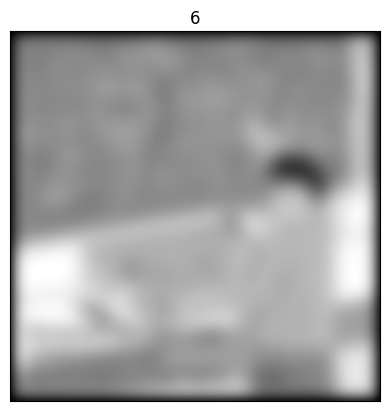

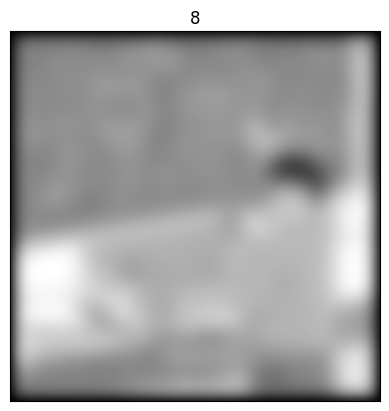

In [27]:
plot_images(unicef_fwd[0:10],2)

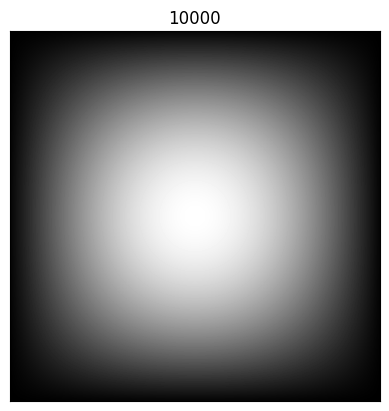

In [28]:
plot_input(unicef_fwd[-1], '10000')

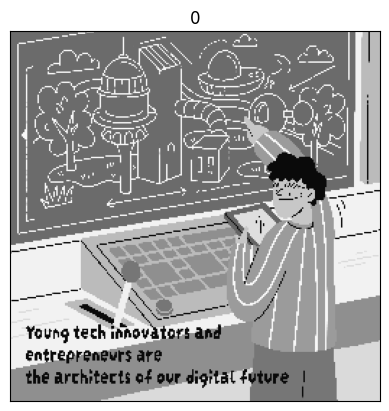

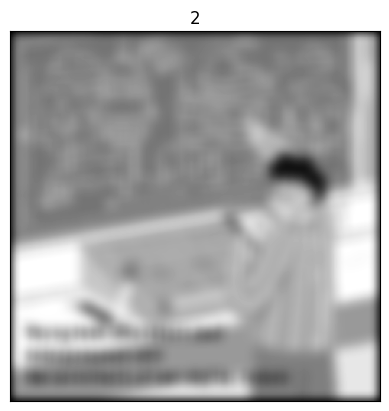

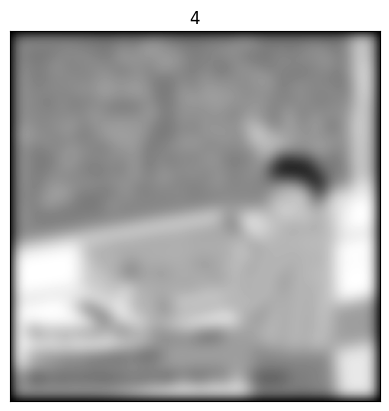

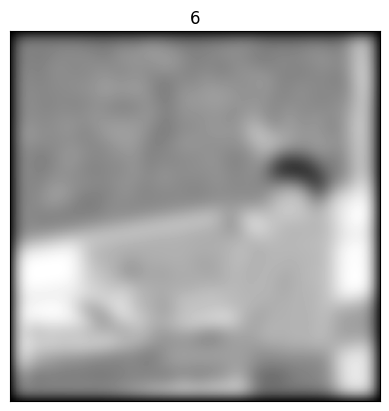

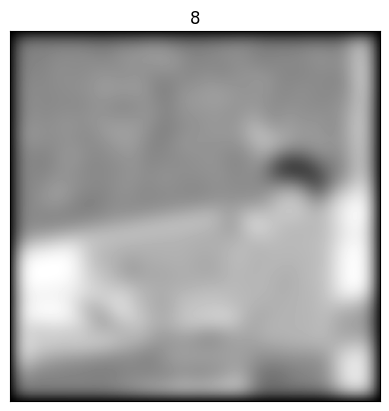

In [53]:
plot_images(unicef_rev[0:10], 2)

In [30]:
reconstructed_unicef = normal_range(unicef_rev[0])

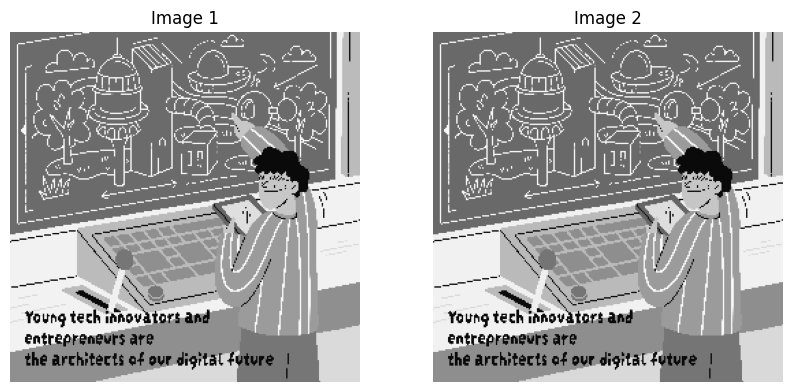

In [31]:
subplot_2(unicef_img, reconstructed_unicef)

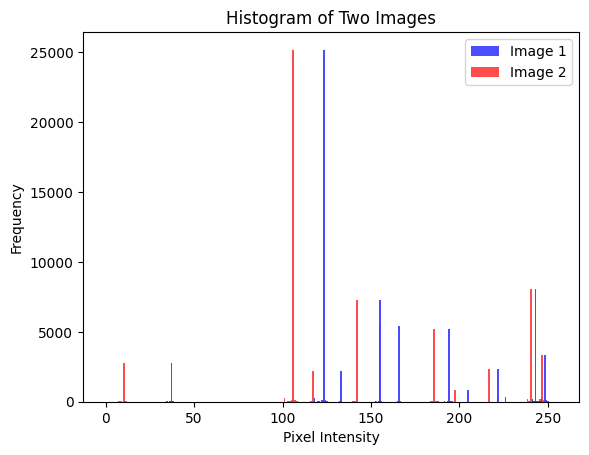

In [32]:
compare_norm_histograms(unicef_img, reconstructed_unicef)

In [33]:
mse(unicef_normal, normalize_image(reconstructed_unicef)) * 100

0.0005885460381354074

In [34]:
compressed_unicef, centres_1 = jacobi_compression(reconstructed_unicef, 8)

In [35]:
compressed_unicef = normal_range(compressed_unicef)

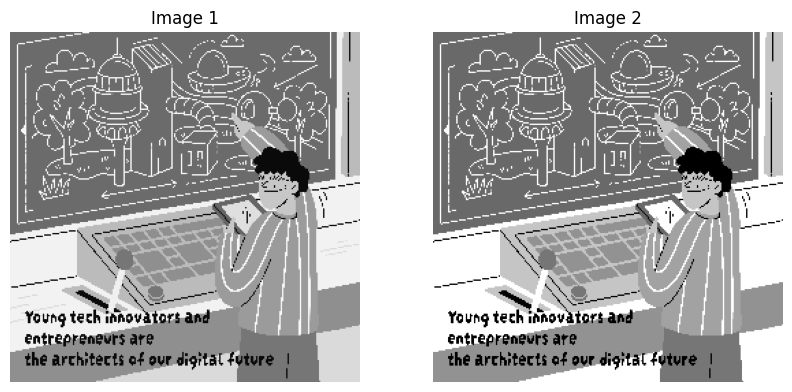

In [36]:
subplot_2(unicef_img, compressed_unicef)

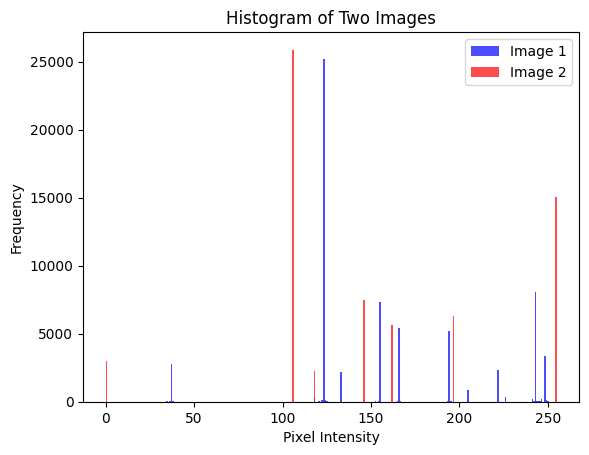

In [37]:
compare_norm_histograms(unicef_img, compressed_unicef)

In [38]:
entropy_unicef = skimage.measure.shannon_entropy(unicef_img) 
entropy_compressed_unicef = skimage.measure.shannon_entropy(compressed_unicef) 

entropy_unicef, entropy_compressed_unicef

(3.112963407505303, 2.3780651112120452)

In [39]:
mse(unicef_normal, normalize_image(reconstructed_unicef)) * 100, mse(unicef_normal, normalize_image(compressed_unicef)) * 100

(0.0005885460381354074, 0.1617518395733385)

### Architecture image (fewer steps)

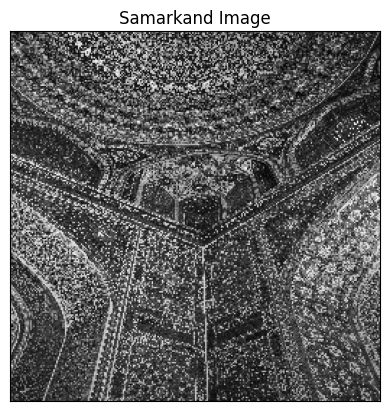

In [40]:
samarkand_img = cv.imread('../images/axp-photography-GQ1fXkYGS40-unsplash.jpg', 0) 
samarkand_img = cv.resize(samarkand_img, (256,256)) 
samarkand_normal = normalize_image(samarkand_img)
plot_input(samarkand_img, 'Samarkand Image')

In [41]:
samarkand_rev, samarkand_fwd = reverse_heat_equation(jacobi_9, samarkand_img,1000)

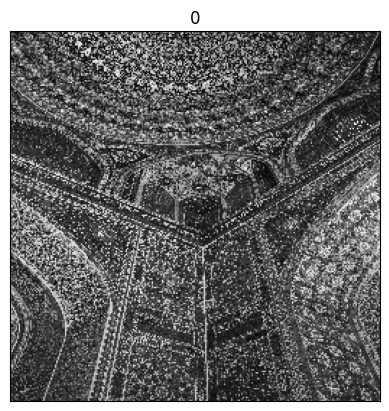

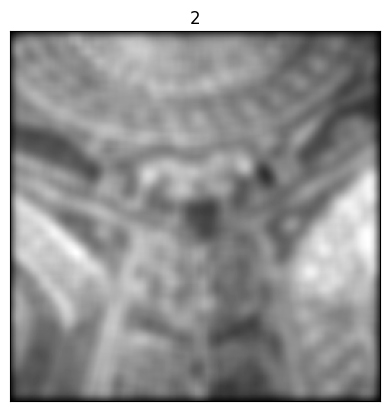

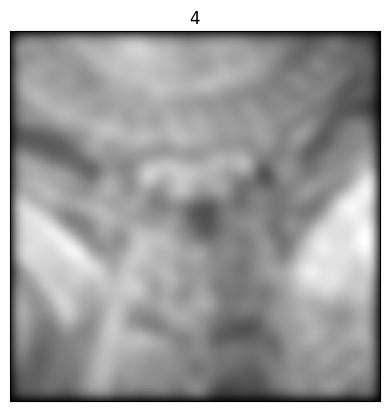

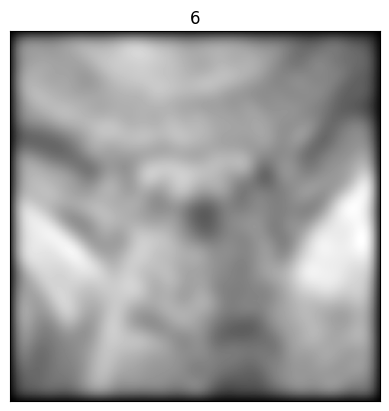

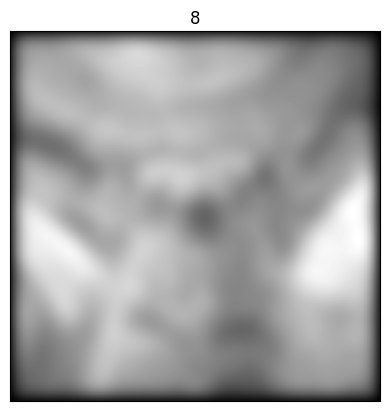

In [42]:
plot_images(samarkand_fwd[0:10],2)

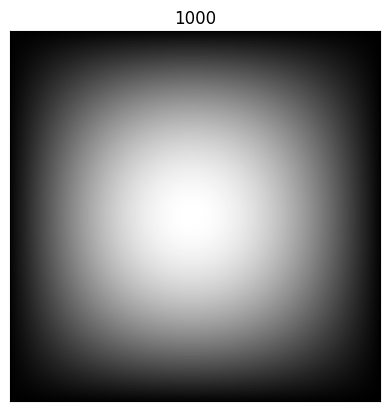

In [43]:
plot_input(samarkand_fwd[-1], '1000')

In [44]:
reconstructed_samarkand = normal_range(samarkand_rev[0])

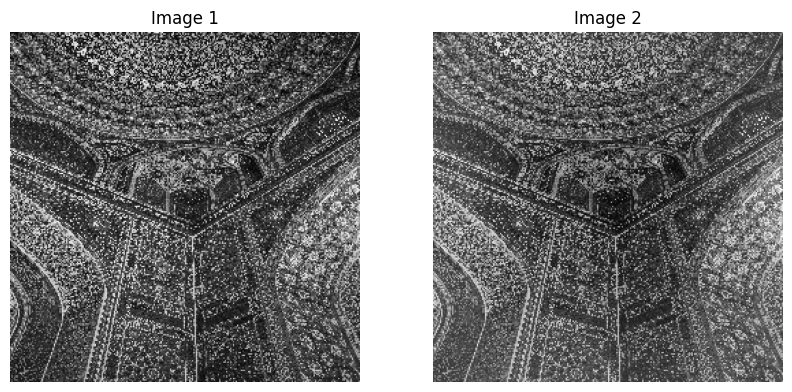

In [45]:
subplot_2(samarkand_img, reconstructed_samarkand)

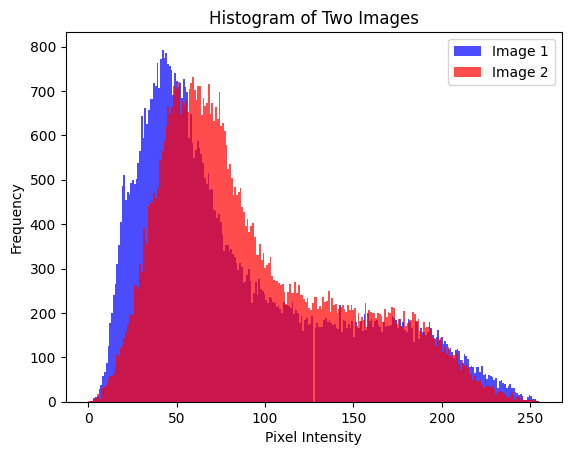

In [46]:
compare_norm_histograms(samarkand_img, reconstructed_samarkand)

In [47]:
mse(samarkand_normal, normalize_image(reconstructed_samarkand))

0.00450723429511333

In [48]:
compressed_samarkand, centres = jacobi_compression(reconstructed_samarkand, 8)

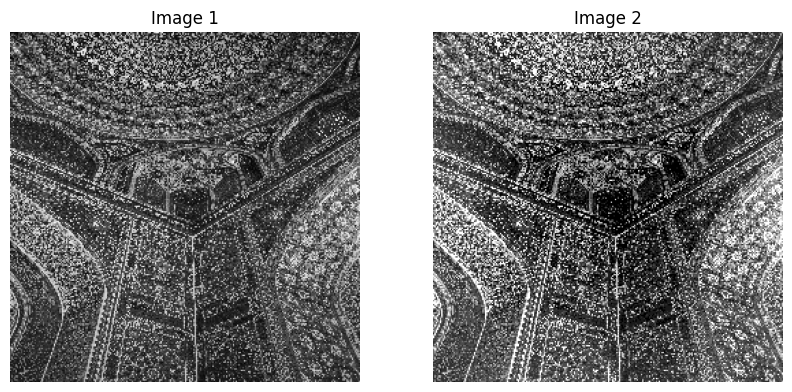

In [49]:
subplot_2(samarkand_img, compressed_samarkand)

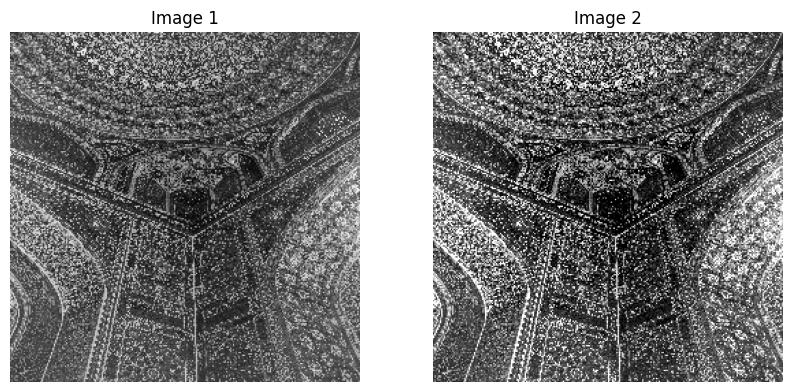

In [50]:
subplot_2(reconstructed_samarkand, compressed_samarkand)

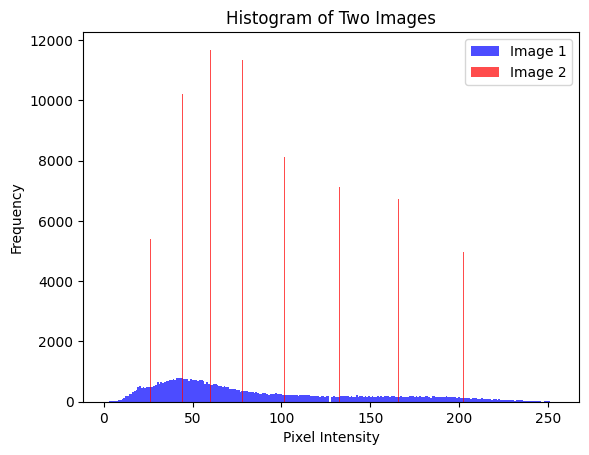

In [51]:
compare_norm_histograms(samarkand_img, compressed_samarkand)

In [52]:
mse(samarkand_normal, normalize_image(compressed_samarkand)), mse(samarkand_normal, normalize_image(reconstructed_samarkand))

(0.011235946534241138, 0.00450723429511333)